# Model testing

- It's just a testing ground for the model. One model is loaded and a `cmc.test_model` is applied on it.
- As a result confusion matrix, ROC, AUROC, F1, PR curves will be generated and saved to the model's folder

In [1]:
import os
from pathlib import Path
import re
import time 
from datetime import datetime
import json

import matplotlib.pyplot as plt
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import pytorch_lightning as pl

import alt_models as am


In [2]:
signal_name = 'mc'
architecture = 'Simple1DCNN'
signal_window = 320
dpoints_in_future = 80
sampling_freq = 150
batch_size = 512
num_workers = 6
num_epochs = 12
learning_rate_min = 0.001
learning_rate_max = 0.01
comment_for_model_name = ''
random_seed = 42

if signal_name == 'mc':
    in_channels = 4
else:
    in_channels = 1

In [3]:
pl.seed_everything(random_seed)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
path = Path(os.getcwd())
comment_for_model_name = architecture  + comment_for_model_name
    
# Load data
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_alt = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_alt['shot']
shots_for_testing = shot_for_alt[shot_for_alt['used_as'] == 'test']['shot']
shots_for_validation = shot_for_alt[shot_for_alt['used_as'] == 'val']['shot']
shots_for_training = shot_for_alt[shot_for_alt['used_as'] == 'train']['shot']
shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_training, shots_for_testing, 
                                                 shots_for_validation, use_ELMS=True, 
                                                 signal_name=signal_name, sampling_freq=sampling_freq)

Seed set to 42


In [5]:
test_df


,time,mcHFS,mcLFS,mcDIV,mcTOP,mode,shot,min_time_diff,prob
0,962.6735,4.549088,-9.120916,0.970168,-5.243067,L-mode,13182,NaN,NaN
1,962.6800,11.009625,-37.698187,1.729787,-5.362853,L-mode,13182,NaN,NaN
2,962.6865,6.995779,-42.522137,1.095978,-6.257895,L-mode,13182,NaN,NaN
3,962.6930,2.836604,-35.935199,0.911982,-6.585671,L-mode,13182,NaN,NaN
4,962.6995,-3.809420,-2.354941,1.713966,-4.750226,L-mode,13182,NaN,NaN
...,...,...,...,...,...,...,...,...,...
505126,1293.1010,198.679501,-105.768412,17.259434,-55.924934,L-mode,20112,NaN,NaN
505127,1293.1075,94.189283,-104.894650,13.565800,-43.642797,L-mode,20112,NaN,NaN
505128,1293.1140,410.464243,-95.241594,10.768569,-50.510229,L-mode,20112,NaN,NaN
505129,1293.1205,424.536374,-96.012814,10.190148,-32.998025,L-mode,20112,NaN,NaN


In [4]:
test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                                balance_data=False, shuffle=False, 
                                signal_window=signal_window,
                                signal_name=signal_name,
                                num_workers=num_workers)

### Load the model

In [6]:
pretrained_model = am.select_model_architecture(architecture=architecture, window=signal_window, 
                                               num_classes=3, in_channels=in_channels)

#Which model to test?
model_path = f'{path}/runs/24-03-21, 15-49-40 Simple1DCNN testing extrasensory model, 4 mirnov_coils, 320 window, 150 sampling_freq'

pretrained_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
pretrained_model.eval()
pretrained_model.to(device)



Simple1DCNN(
  (conv1): Conv1d(4, 128, kernel_size=(32,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(32,), stride=(1,), padding=(1,), dilation=(2,))
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AvgPool1d(kernel_size=(32,), stride=(8,), padding=(0,))
  (max_pool): MaxPool1d(kernel_size=32, stride=8, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

### Test model on unbalanced test dset

In [ ]:
#metrics = cmc.test_model(f'{path}/RIS1 preds for doubtful shots', pretrained_model, test_dataloader_augmented, max_batch=0, comment='augmented_last_fc')
metrics = am.test_model(f'{path}/RIS1 preds for doubtful shots', pretrained_model, 
                        test_dataloader, max_batch=0, comment='', signal_name=signal_name, 
                        return_metrics=False)


In [22]:
preds_csv = pd.read_csv(f'{path}/runs/24-03-21, 15-49-40 Simple1DCNN testing extrasensory model, 4 mirnov_coils, 320 window, 150 sampling_freq/predictions_on_test_dset_df.csv')

### Here the model is tested on individual shots (generates time-confidence graph)

In [ ]:
shots_for_testing_list = list(map(int,shots_for_testing))
img_path = am.per_shot_test(path=f'{path}/RIS1 preds for doubtful shots', shots=shots_for_testing_list, results_df=preds_csv)
plt.close()

In [69]:
shot = 19915
%matplotlib widget


preds_csv = pd.read_csv(f'{path}/runs/24-03-21, 15-49-40 Simple1DCNN testing extrasensory model, 4 mirnov_coils, 320 window, 150 sampling_freq/predictions_on_test_dset_df.csv')
pred_for_shot = preds_csv[preds_csv['shot']==shot]
h_alpha = pd.read_csv(f'{path}/data/h_alpha_signal_{sampling_freq}kHz/shot_{shot}.csv')

#norming h_alpha
h_alpha['h_alpha'] = (h_alpha['h_alpha'] - h_alpha['h_alpha'].min())/h_alpha['h_alpha'].max()


# these are matplotlib.patch.Patch properties
df_merged = pd.merge_asof(pred_for_shot, h_alpha, on='time', tolerance=1/sampling_freq, direction='nearest')



In [72]:
shot_df

,time,mcHFS,mcLFS,mcDIV,mcTOP,mode,shot
0,962.6735,4.549088,-9.120916,0.970168,-5.243067,0,13182
1,962.6800,11.009625,-37.698187,1.729787,-5.362853,0,13182
2,962.6865,6.995779,-42.522137,1.095978,-6.257895,0,13182
3,962.6930,2.836604,-35.935199,0.911982,-6.585671,0,13182
4,962.6995,-3.809420,-2.354941,1.713966,-4.750226,0,13182
...,...,...,...,...,...,...,...
2206191,1136.6200,122.989786,-94.654459,278.613078,-44.206942,0,20147
2206192,1136.6265,126.479689,-88.791877,250.710774,-53.786190,0,20147
2206193,1136.6330,141.452929,-90.112426,228.233099,-53.157950,0,20147
2206194,1136.6395,143.293452,-89.355592,208.566483,-40.394718,0,20147


Text(0.5, 0, 't [ms]')

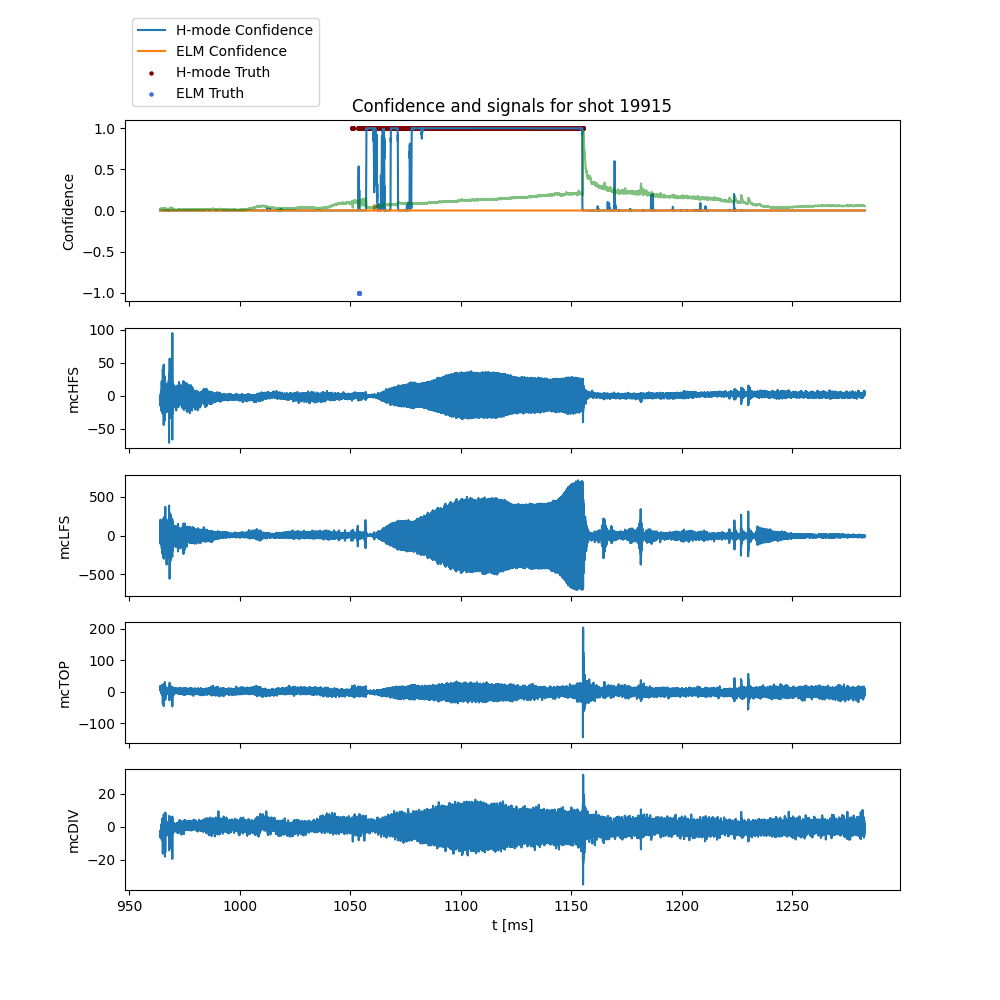

In [71]:

conf_time_fig, conf_time_ax = plt.subplots(5,1, sharex=True, figsize=(10,10),gridspec_kw={'height_ratios': [1.5, 1,1,1,1]})
conf_time_ax[0].plot(df_merged['time'],df_merged['H_logit'], label='H-mode Confidence')
conf_time_ax[0].plot(df_merged['time'],df_merged['ELM_logit'], label='ELM Confidence')
conf_time_ax[0].scatter(df_merged[df_merged['label']==1]['time'], 
                  len(df_merged[df_merged['label']==1])*[1], 
                  s=5, alpha=1, label='H-mode Truth', color='maroon')
        
conf_time_ax[0].scatter(df_merged[df_merged['label']==2]['time'], 
                  len(df_merged[df_merged['label']==2])*[-1], 
                  s=5, alpha=1, label='ELM Truth', color='royalblue')
conf_time_ax[0].set_title(f'Confidence and signals for shot {shot}')

conf_time_ax[0].set_ylabel('Confidence')
conf_time_ax[0].legend(loc='upper left', bbox_to_anchor=(0,1.6))

conf_time_ax[1].plot(df_merged['time'],shot_df[shot_df['shot']==shot]['mcHFS'].values, label='mcHFS')
conf_time_ax[2].plot(df_merged['time'],shot_df[shot_df['shot']==shot]['mcLFS'].values, label='mcLFS')
conf_time_ax[3].plot(df_merged['time'],shot_df[shot_df['shot']==shot]['mcTOP'].values, label='mcTOP')
conf_time_ax[4].plot(df_merged['time'],shot_df[shot_df['shot']==shot]['mcDIV'].values, label='mcDIV')


conf_time_ax[0].plot(df_merged['time'],df_merged['h_alpha'].values, label='H_alpha', color='green', alpha=0.5)

for i, signal_label in enumerate(['mcHFS', 'mcLFS', 'mcTOP', 'mcDIV']):
    conf_time_ax[i+1].set_ylabel(signal_label)


conf_time_ax[4].set_xlabel('t [ms]')